In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from func import *

In [2]:
def popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2=False):
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave < 5090*k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1
    popt_full_fit,pcov_full_fit = leastsq(full_gauss,x0=p_init,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    Monte_Carlo_loops = 2
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(full_gauss,x0=popt_full_fit,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        parameters_MC[:,l]=popt_MC
    parameters_err = np.std(parameters_MC,1)  
    (amp_Hb_error,amp_OIII5007_error,vel_OIII_error,vel_sigma_OIII_error,amp_Hb_br_error,amp_OIII5007_br_error,vel_OIII_br_error,vel_sigma_OIII_br_error,amp_Hb1_error,amp_Fe5018_1_error,vel_Hb1_error,vel_sigma_Hb1_error,amp_Hb2_error,amp_Fe5018_2_error,vel_Hb2_error,vel_sigma_Hb2_error,m_error,c_error) = parameters_err
    return popt_full_fit,parameters_err 

In [3]:
def plot(obj,wo_wave,data,error,z,popt_full_fit,broad2=False):
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit) = popt_full_fit
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave < 5090*k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1

    fit = full_gauss(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
    residual = data[select] - fit
    plt.plot(wo_wave[select],data[select],'k-',label='data')
    plt.plot(wo_wave[select],fit,'r-',label='fit')
    plt.plot(wo_wave[select],residual,label='residual')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit) + continuum(wo_wave[select],m_fit,c_fit),'-g',label='core')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit) + continuum(wo_wave[select],m_fit,c_fit),color ='purple',label='wing')
    plt.plot(wo_wave[select],Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit) + continuum(wo_wave[select],m_fit,c_fit),color ='brown',label='BLR1')
    plt.plot(wo_wave[select],Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit) + continuum(wo_wave[select],m_fit,c_fit),'-c',label='BLR2')
    plt.title('%s_brightest_pixel_fit'%(obj))
    plt.xlabel(r"Wavelength ($\AA$)")
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$) ")
    plt.legend()
    plt.show()     
    


In [4]:
def central_table(obj,popt_full_fit,brightest_pixel_x,brightest_pixel_y,parameters_err):
    central_coordinates = [int(brightest_pixel_x),int(brightest_pixel_y)]
    print central_coordinates
    popt = np.append(popt_full_fit,central_coordinates)
    central_cordinates_err = [0,0]
    err = np.append(parameters_err,central_cordinates_err)
    column_names={'amp_Hb':0,'amp_OIII5007':1,'vel_OIII':2,'vel_sigma_OIII':3,'amp_Hb_br':4,'amp_OIII5007_br':5,'vel_OIII_br':6,
              'vel_sigma_OIII_br':7,'amp_Hb1':8,'amp_Fe5018_1':9,'vel_Hb1':10,'vel_sigma_Hb1':11,'amp_Hb2':12,
              'amp_Fe5018_2':13,'vel_Hb2':14,'vel_sigma_Hb2':15,'m':16,'c':17,'central_x':18,'central_y':19}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s_central_fit.fits'%(obj),overwrite=True)



In [5]:
def algorithm_script(obj,p_init,z,broad2,prefix_path_cube="/home/mainak/xdata/ftp.hidrive.strato.com/users/login-carsftp"):
    print '%s'%(obj)
    try:
        (orig_cube,orig_err,orig_wave,orig_header) = loadCube('%s/MUSE/%s/%s.binned.fits'%(prefix_path_cube,obj,obj))
    except IOError:
        (orig_cube,orig_err,orig_wave,orig_header) = loadCube('%s/MUSE/%s/%s.unbinned.fits'%(prefix_path_cube,obj,obj))   
    (cont_cube,cont_err,cont_wave,cont_header) = loadCube('%s/MUSE/%s/%s.cont_model.fits'%(prefix_path_cube,obj,obj))
    (QSO_cube,QSO_err,QSO_wave,QSO_header) = loadCube('%s/MUSE/%s/%s.QSO_full.fits'%(prefix_path_cube,obj,obj))
    
    difference = difference_in_wavelength_dimension(orig_cube,cont_cube)
    
    (wo_cube,wo_err,wo_wave,wo_header) = create_wo_absorption_cube(obj,orig_cube,orig_err,orig_header,cont_cube,cont_wave,difference)
    
    [brightest_pixel_x,brightest_pixel_y] = brightest_pixel(QSO_cube,wo_cube,wo_wave,z)
    
    (data,error) = (wo_cube[:,brightest_pixel_y,brightest_pixel_x],wo_err[:,brightest_pixel_y,brightest_pixel_x])
    
    (popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2)
    
    print popt_full_fit
    
    plot(obj,wo_wave,data,error,z,popt_full_fit,broad2)
    
    central_table(obj,popt_full_fit,brightest_pixel_x,brightest_pixel_y,parameters_err)

HE2233+0124
[8.93995101e-02 8.95735882e-01 1.69853721e+04 1.73134268e+02
 5.71737844e-02 1.49671268e-01 1.70432028e+04 5.21973760e+02
 2.13665682e-01 8.59038152e-04 1.87345745e+04 4.17262389e+03
 1.48526497e-01 3.64343315e-03 1.51742024e+04 1.28723295e+03
 1.78429184e-02 1.69501004e-01]


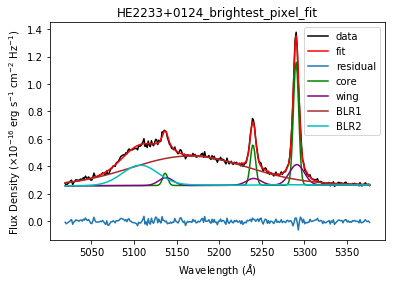

[34, 82]
HE0429-0247
[ 6.77530456e-01  9.34047865e+00  1.26313661e+04  9.41997925e+01
  1.35010060e+00  1.18826151e+00  1.25606223e+04  2.70531645e+02
  7.26853130e-01  1.35535740e-02  1.30291051e+04  1.78843744e+02
  1.59067498e+00  2.29455853e-01  1.26526696e+04  1.44573059e+03
 -5.97979692e-01  4.40126104e+00]


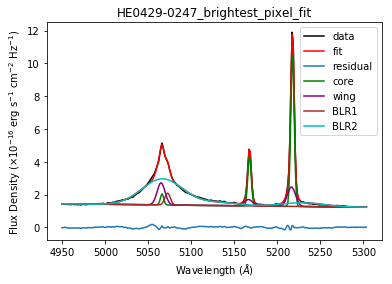

[75, 82]
HE0232-0900
[ 3.45960494e+00  3.53875928e+01  1.29027549e+04  1.32362217e+02
  7.62129593e-02  1.68628227e+01  1.28203462e+04  2.86151156e+02
  7.66336646e+00  1.22101211e+00  1.28869261e+04  2.17229905e+03
  0.00000000e+00  0.00000000e+00  1.29420000e+04  1.00000000e+03
 -4.04896348e+00  2.87526438e+01]


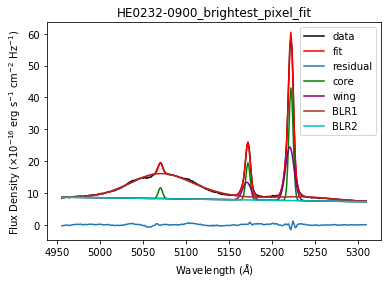

[67, 51]
HE2222-0026
[ 7.70965901e-02  4.21872066e-01  1.74026229e+04  1.38578312e+02
 -2.45955872e-02  8.41200738e-02  1.71619842e+04  2.97624274e+02
  1.24453757e-01  1.50533942e-02  1.85263368e+04  6.35139264e+02
  2.00626201e-01  2.47352773e-02  1.74712181e+04  1.73309039e+03
  1.11035405e-02  1.43466472e-01]


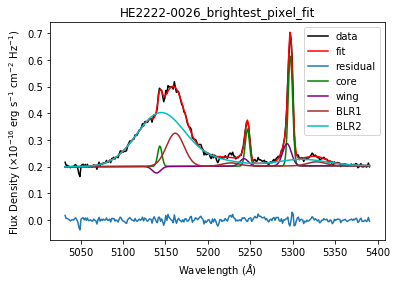

[92, 90]
HE0021-1819
[ 1.23753927e-01  1.63323600e+00  1.59598246e+04  7.28313267e+01
  5.29284629e-02  3.31769425e-01  1.58048063e+04  2.93629718e+02
  5.37437158e-02  7.93226692e-03  1.59803598e+04  1.72572712e+03
  0.00000000e+00  0.00000000e+00  1.59590000e+04  1.00000000e+03
 -2.67925706e-02  2.00098391e-01]


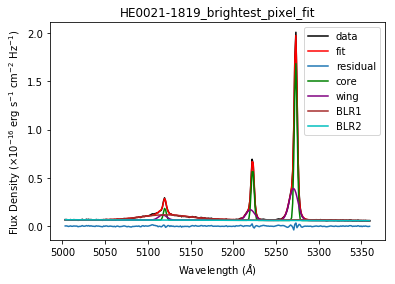

[116, 153]
HE0853+0102
[ 1.00298117e-01  9.50102730e-01  1.57079033e+04  1.02513062e+02
  1.56811370e-02  2.95780515e-01  1.56723469e+04  3.16686887e+02
  1.21654161e-01  1.83595630e-02  1.52410568e+04  1.43468617e+03
  1.14010917e-01  1.42477160e-02  1.69963409e+04  1.21202806e+03
 -1.75099205e-02  1.93950739e-01]


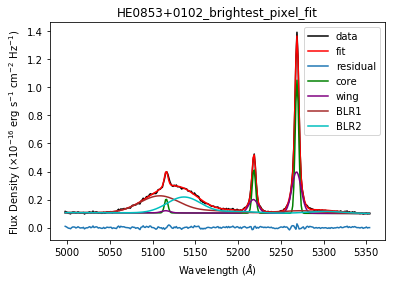

[162, 116]
HE1011-0403
[ 1.50798754e-01  1.10279086e+00  1.75313386e+04  1.08003576e+02
  1.01368916e-01  5.38051043e-01  1.72956920e+04  2.59074684e+02
  2.28502166e-01  1.18886173e-02  1.77616958e+04  1.63870963e+03
  7.61545725e-01  1.02093538e-01  1.76815260e+04  8.25497166e+02
 -2.83240277e-01  2.24214686e+00]


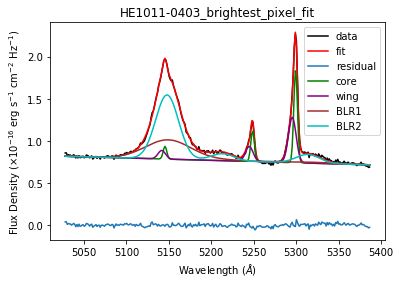

[189, 222]
HE0040-1105
[2.26536854e-01 2.64650874e+00 1.26366082e+04 7.69823347e+01
 8.83451026e-02 5.62030165e-01 1.24720537e+04 2.52411438e+02
 3.47123159e-01 4.71160761e-02 1.29889234e+04 1.20889312e+03
 1.00000000e-03 1.00000000e-03 1.25070000e+04 1.00000000e+03
 7.30225839e-03 1.98859612e-01]


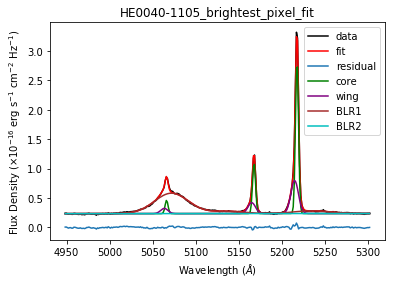

[191, 151]
HE0253-1641
[ 2.92899287e+00  1.97819138e+01  9.49157119e+03  1.70051843e+02
  3.77407643e+00  1.73922283e+00  9.56279906e+03  9.67401996e+02
 -4.56293512e+02  6.33535710e+03 -7.61446889e+05  1.08540053e+04
  4.59770768e+02 -6.33431758e+03  1.55136114e+06 -1.83876125e+04
 -2.19532642e-01  5.65930099e+00]


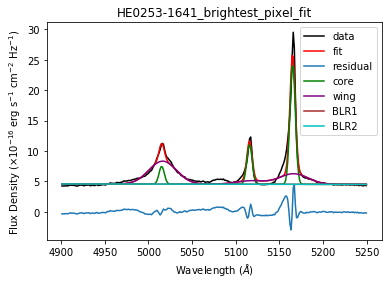

[96, 41]
HE0119-0118
[ 1.44428503e+00  1.28339364e+01  1.63325524e+04  1.10890882e+02
  4.28031363e-01  8.73319908e+00  1.61239994e+04  2.46251601e+02
  1.52491234e+00  5.76245659e-02  1.65552546e+04  9.85815590e+02
  1.41294186e+00  4.16093651e-01  1.63377808e+04  2.46204975e+03
 -1.57122766e+00  1.05304345e+01]


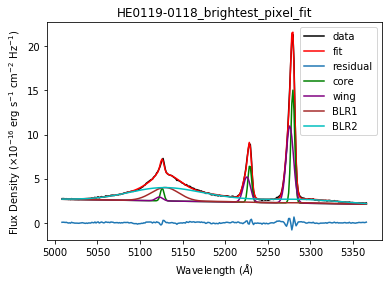

[113, 80]
HE0934+0119
[ 2.56406666e-01  1.79190054e+00  1.52081172e+04  6.79716723e+01
  1.57207502e-01  9.08809750e-01  1.50798360e+04  1.68130285e+02
  7.62709265e-01  9.46835693e-02  1.52030316e+04  5.25123033e+02
  4.72382399e-01  6.04939353e-02  1.52066437e+04  1.27097465e+03
 -2.02391244e-01  1.57077172e+00]


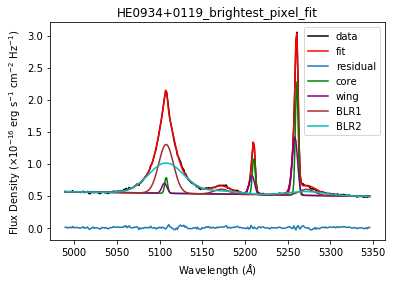

[155, 163]
HE1017-0305
[ 1.00871282e-01  1.51664154e+00  1.46792265e+04  4.74849451e+01
  8.18111676e-02  3.83851614e-01  1.46107756e+04  2.07654151e+02
  6.68678671e-01  8.80558272e-02  1.45100584e+04  1.96919559e+03
  0.00000000e+00  0.00000000e+00  1.49950000e+04  1.00000000e+03
 -3.11828140e-01  2.22975726e+00]


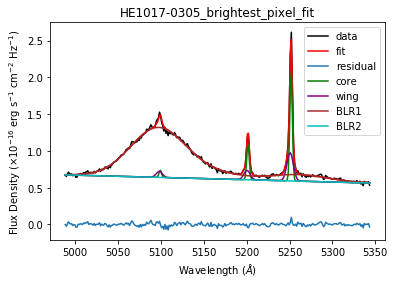

[87, 109]
HE0345+0056
[5.00063809e-01 1.72484506e+01 9.17861676e+03 1.61187180e+02
 4.62788833e+00 1.13725764e+01 8.84875343e+03 3.97940087e+02
 8.96017485e+00 1.77176599e+00 9.33901888e+03 1.55043485e+03
 2.75706058e+01 2.63202615e+00 9.34259398e+03 3.25140395e+02
 3.34278351e-01 7.16996697e+00]


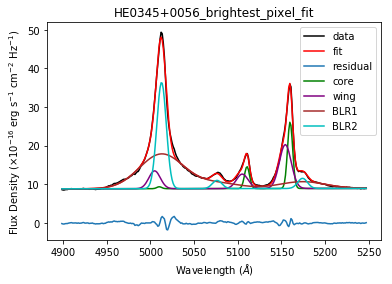

[79, 80]
HE0412-0803
[ 1.64487639e+00  2.26575889e+01  1.14672840e+04  9.16229715e+01
  5.30905807e-01  4.34556977e+00  1.14602568e+04  2.75906557e+02
  1.54605384e+00  2.04926299e-01  1.13065663e+04  1.78939165e+03
  0.00000000e+00  0.00000000e+00  1.14480000e+04  1.00000000e+03
 -3.87254762e-01  3.00959570e+00]


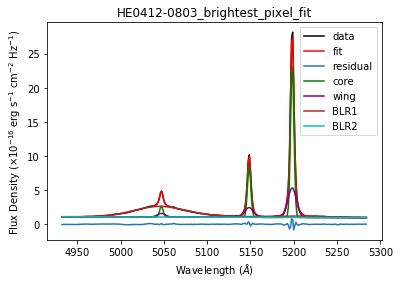

[179, 160]
HE0108-4743
[ 1.68425479e+00  4.86585792e+00  7.22949012e+03  5.41479019e+01
  1.42694253e-01  1.73981701e+00  7.16251088e+03  1.42427565e+02
  3.85985047e-01  8.98646942e-02  7.24757004e+03  1.22892489e+03
  1.19935362e+00  2.05433793e-01  7.24845818e+03  4.32984789e+02
  2.97577831e-01 -8.61409193e-01]


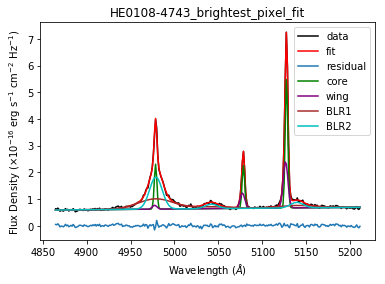

[79, 79]
HE0433-1028
[ 6.29517495e-01  4.33434740e+00  1.05792853e+04  1.29671448e+02
  5.45622010e-01  4.89413332e+00  1.02691786e+04  3.30583566e+02
  2.40672716e+00  2.60278348e-01  1.05122283e+04  9.75025281e+02
  1.07904911e+00  3.05058716e-01  1.13343971e+04  2.14629600e+03
 -6.76493773e-01  5.23601933e+00]


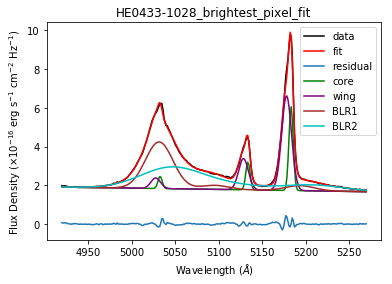

[150, 157]
HE1330-1013
[ 1.36952396e-01  5.73526946e-01  6.74165975e+03  8.04999579e+01
  5.32708843e-02  1.55597817e-01  6.56744404e+03  2.11655583e+02
  1.27692524e-01  3.85227890e-02  6.94850265e+03  1.58560592e+03
  2.84033700e-01  4.15390867e-02  6.81092371e+03  6.15362628e+02
 -1.74411050e-02  2.87633150e-01]


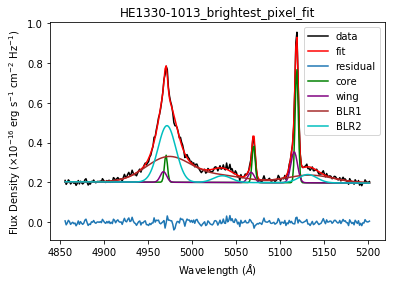

[157, 160]
HE1417-0909
[ 9.24926376e-01  1.31504789e+01  1.30870357e+04  6.43452142e+01
  1.50882915e-01  2.50839453e+00  1.30426986e+04  1.78065299e+02
  1.48223088e+00  1.71792929e-01  1.32270405e+04  1.46353527e+03
  0.00000000e+00  0.00000000e+00  1.32000000e+04  1.00000000e+03
 -7.56279211e-01  5.05736149e+00]


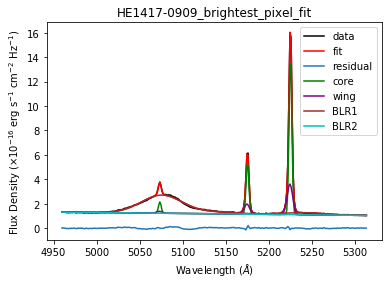

[41, 45]
HE0227-0913
[ 3.10303324e+00  5.83299392e+00  4.78549496e+03  1.37370226e+02
  2.01892736e+00  6.59960321e-01  4.38532010e+03  3.14984635e+02
  3.15886343e+00  4.57625726e-01  4.71160198e+03  1.34228224e+03
  7.03945039e+00  1.76694491e+00  4.91287937e+03  3.99250240e+02
 -2.97896280e-01  4.71218354e+00]


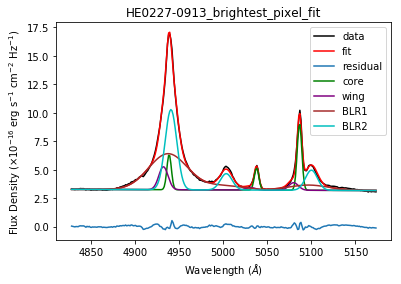

[115, 87]
HE1029-1831
[ 6.42815151e-01  5.23402288e-01  1.21159027e+04  7.97795556e+01
  1.67598813e-01  1.19031430e+00  1.19896847e+04  2.25797257e+02
  3.10850986e-01  7.65998314e-02  1.21272534e+04  1.50081981e+03
  3.09600254e-01  3.88105543e-02  1.25788366e+04  7.95824365e+02
 -2.69339433e-02  5.66158453e-01]


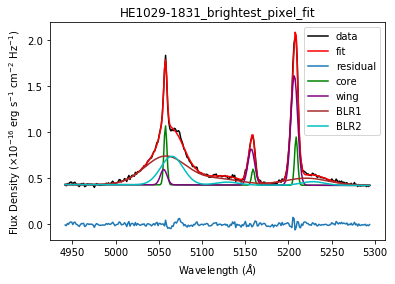

[155, 218]
HE2302-0857
[ 8.92518394e-01  8.18476213e+00  1.41190203e+04  1.84759868e+02
  3.25452398e-03  1.37995233e+00  1.43503180e+04  4.96628731e+02
  5.33551521e-01  1.25468451e-02  1.53706535e+04  1.41185242e+03
  7.19130816e-01  2.06945515e-01  1.28875405e+04  2.04727695e+03
 -6.40058047e-01  4.68950167e+00]


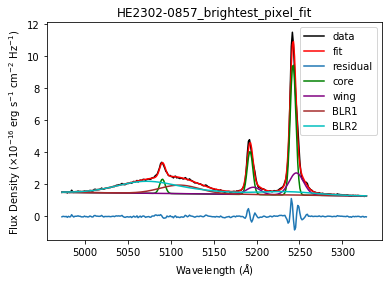

[138, 160]
HE1107-0813
[ 5.46676427e-02  2.58205782e-01  1.75429496e+04  8.49051310e+01
  2.07716636e-01  1.38848204e-01  1.73842196e+04  5.07519981e+02
  8.66652635e-01  3.59426216e-01  1.75395868e+04  9.88168227e+02
  8.77363501e-01  7.65004345e-02  1.68587891e+04  1.97483519e+03
 -8.35505942e-01  7.28320394e+00]


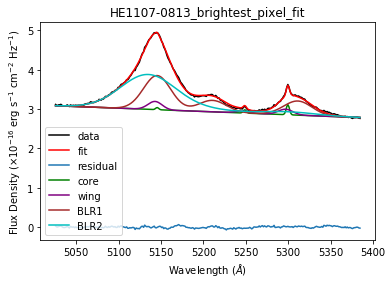

[161, 158]
HE0114-0015
[ 2.21302626e-01  4.65858181e-01  1.36721834e+04  1.08039433e+02
  2.18226143e-02  7.17551279e-02  1.35901851e+04  3.46261220e+02
  1.08486278e-01  3.62824634e-02  1.36786575e+04  1.18693125e+03
  0.00000000e+00  0.00000000e+00  1.36800000e+04  1.00000000e+03
 -7.82877212e-03  1.24279767e-01]


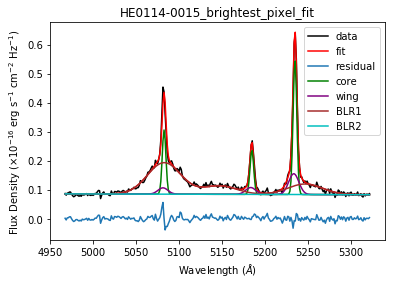

[167, 162]
HE2211-3903
[3.89330624e-01 2.77844845e+00 1.18532315e+04 7.35582135e+01
 4.95620642e-02 1.12685355e-01 1.15131985e+04 9.46991475e+01
 3.55168373e-01 4.83830289e-02 1.16398482e+04 2.56726898e+03
 0.00000000e+00 0.00000000e+00 1.19140000e+04 1.00000000e+02
 3.15027779e-02 6.52120230e-01]


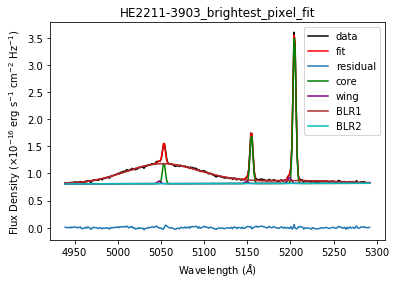

[156, 164]
HE1108-2813
[ 1.45834547e+00  3.17381257e+00  7.16227199e+03  7.03141533e+01
  7.18972998e-01  1.47731658e+00  7.04062124e+03  2.62001371e+02
  1.40269798e+00  3.57711711e-01  7.36924998e+03  1.23727808e+03
  0.00000000e+00  0.00000000e+00  7.20000000e+03  1.00000000e+03
 -5.97175257e-01  4.84639920e+00]


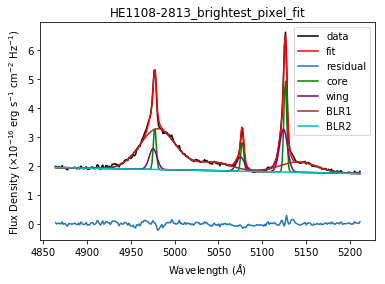

[158, 152]
HE1126-0407
[ 1.02621636e+00  1.34514046e+01  1.80271224e+04  1.19160713e+02
  2.45911755e+00  2.85585351e+00  1.77552694e+04  3.52210072e+02
  9.90696764e+00  1.34329299e+00  1.80797256e+04  7.14356228e+02
  7.36002856e+00  1.71395134e+00  1.79758879e+04  1.77426753e+03
 -8.43050832e-01  1.41254018e+01]


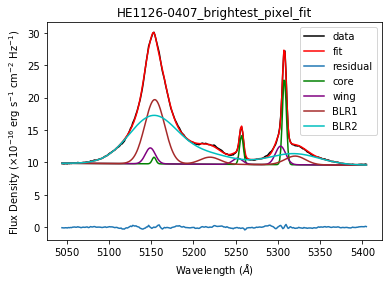

[76, 80]
HE0351+0240
[ 2.19267953e+00  3.70350892e+01  1.06360099e+04  6.78448136e+01
  1.09818527e+00  1.50731887e+00  1.06183087e+04  2.74679155e+02
  1.52212024e+00  7.52619754e-02  1.15805760e+04  3.14903785e+02
  3.47713118e+00  3.52173290e-01  1.06529602e+04  1.34335889e+03
 -2.90730137e-01  3.33251174e+00]


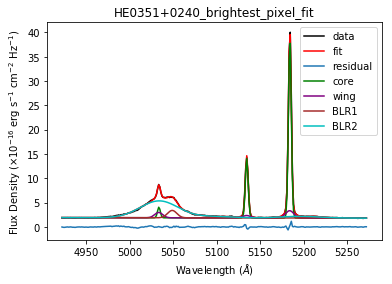

[75, 93]
HE0224-2834
[ 1.97564101e-01  2.31978739e+00  1.79894843e+04  1.04790314e+02
  7.20523108e-02  1.02515189e+00  1.79681200e+04  2.54087750e+02
  3.65213167e-01  4.80307979e-02  1.80109350e+04  2.17858677e+03
  0.00000000e+00  0.00000000e+00  1.79400000e+04  1.50000000e+03
 -1.02899498e-01  9.14819157e-01]


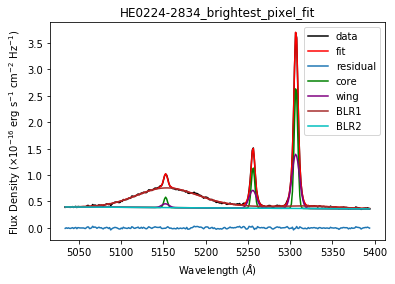

[81, 77]
HE1353-1917
[ 7.50053652e-02  7.89602614e-01  1.04883119e+04  8.24372236e+01
  3.70442003e-02  9.72573184e-02  1.02852534e+04  4.88168428e+02
  1.30859192e-01  1.43541279e-02  8.70078823e+03  1.60430387e+03
  1.09746212e-01  2.00313685e-02  1.25019726e+04  1.47588305e+03
 -1.18143287e-01  1.05188271e+00]


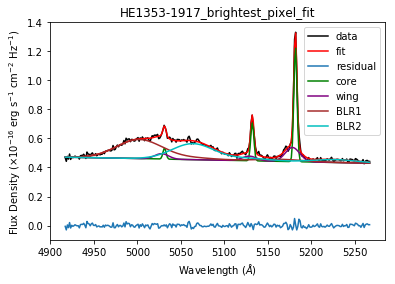

[200, 195]


In [6]:
z = {"HE0021-1819":0.053197,"HE0040-1105":0.041692,"HE0108-4743":0.02392,"HE0114-0015":0.04560
    ,"HE0119-0118":0.054341,"HE0224-2834":0.059800,"HE0227-0913":0.016451,"HE0232-0900":0.043143,"HE0253-1641":0.031588
    ,"HE0345+0056":0.031,"HE0351+0240":0.036,"HE0412-0803":0.038160,"HE0429-0247":0.042009,"HE0433-1028":0.035550
    ,"HE0853+0102":0.052,"HE0934+0119":0.050338,"HE1011-0403":0.058314,"HE1017-0305":0.049986,"HE1029-1831":0.040261
    ,"HE1107-0813":0.058,"HE1108-2813":0.024013,"HE1126-0407":0.061960,"HE1330-1013":0.022145,"HE1353-1917":0.035021
    ,"HE1417-0909":0.044,"HE2211-3903":0.039714,"HE2222-0026":0.059114,"HE2233+0124":0.056482,"HE2302-0857":0.046860}

#z_remaining = {"HE2128-0221":0.05248,"HE1248-1356":0.01465}

objs = z.keys()

broad2= {'HE0021-1819':False,'HE0040-1105':False,'HE0108-4743':True,'HE0114-0015':False
        ,'HE0119-0118':True,'HE0224-2834':False,'HE0227-0913':True,'HE0232-0900':False,'HE0253-1641':True
        ,'HE0345+0056':True,'HE0351+0240':True,'HE0412-0803':False,'HE0429-0247':True,'HE0433-1028':True
        ,'HE0853+0102':True,'HE0934+0119':True,'HE1011-0403':True,'HE1017-0305':False,'HE1029-1831':True
        ,'HE1107-0813':True,'HE1108-2813':False,'HE1126-0407':True,'HE1330-1013':True,'HE1353-1917':True
        ,'HE1417-0909':False,'HE2211-3903':False,'HE2222-0026':True,'HE2233+0124':True,'HE2302-0857':True}

p_init= {'HE0021-1819':[1,12.5,15959,50.0,3,3,15759,200.0,2,2,15959,1000.0,0,0,15959,1000.0,-0.001,0.1]
        ,'HE0040-1105':[1.139,1.5,12507.0,50.0,1.0,3.0,12307.0,100.0,1.0,1.0,12507,1000.0,0.001,0.001,12507,1000.0,-0.001,2.0]
        ,'HE0108-4743':[1.139,1.5,7176.0,100.0,1.0,3.0,6976.0,200.0,1.0,1.0,7176,1200.0,1.0,1.0,7176,1000.0,-0.001,2.0]
        ,'HE0114-0015':[0.1,1.5,13680,50.0,1.0,3.0,13480,100.0,1.0,1.0,13680,1000.0,0,0,13680,1000.0,-0.001,0.3]
        ,'HE0119-0118':[1,12.5,16302,50.0,3,3,16102,100.0,2,2,16302,1000.0,1,1,16302,2500.0,-0.001,0.1]
        ,'HE0224-2834':[0.2,2.5,17940,50.0,0.3,0.3,17640,200.0,0.1,0.1,17940,1500.0,0,0,17940,1500.0,-0.001,0.1]
        ,'HE0227-0913':[0.1,0.9,4935,50.0,0.1,0.1,4835,100.0,0.1,0.1,4935,1000.0,0.1,0.1,4935,1000.0,-0.001,0.1]
        ,'HE0232-0900':[2,40,12942,50.0,5,5,12742,100.0,5,1,12942,1000.0,0,0,12942,1000.0,-0.001,0.1]                                     
        ,'HE0253-1641':[1.81435760e+00,1.86344206e+01,9.53711474e+03,1.08517137e+02,1.16410886e+00,6.75794894e+00,9.28646315e+03,3.70444283e+02,2.76153947e+00,7.69836961e-01,9.76214125e+03,5.47246542e+02,1.68654961e+00,3.70637199e-01,9.24193020e+03,1.75921264e+03,1.11573423e-01,3.75777773e+00]
        ,'HE0345+0056':[4.81041928e-01,1.72498857e+01,9.17858648e+03,1.65298937e+02,4.62881942e+00,1.13736585e+01,8.84870644e+03,4.00709613e+02,8.96185243e+00,1.76889989e+00,9.33926172e+03,1.55096532e+03,2.75860651e+01,2.63166947e+00,9.34250378e+03,3.28089905e+02,3.35713532e-01,7.16315181e+00]
        ,'HE0351+0240':[2.19264502e+00,3.70402407e+01,1.06360169e+04,7.72338448e+01,1.10298241e+00,1.50249383e+00,1.06183228e+04,2.77549457e+02,1.52283432e+00,7.54204519e-02,1.15806639e+04,3.17978311e+02,3.47577206e+00,3.51692202e-01,1.06529589e+04,1.34441236e+03,-2.90461186e-01,3.33119886e+00]
        ,'HE0412-0803':[1.139,1.5,11448,50.0,0.1,0.3,11248,100.0,0.1,0.1,11448,1000.0,0,0,11448,1000.0,-0.001,0.5]
        ,'HE0429-0247':[6.78042306e-01,9.34310769e+00,1.26313529e+04,1.01154932e+02,1.35047428e+00,1.18529424e+00,1.25605371e+04,2.73304829e+02,7.26932356e-01,1.37289537e-02,1.30289568e+04,1.84524586e+02,1.59025415e+00,2.29220666e-01,1.26527939e+04,1.44670301e+03,-5.97866189e-01,4.40069812e+00]
        ,'HE0433-1028':[0.9,4.0,10600.0,100.0,1.0,1.0,10400.0,1000.0,1.0,1.0,10665,1000.0,0.1,0.1,10665,1000.0,-0.1,1.0]
        ,'HE0853+0102':[0.1,0.9,15600,50.0,0.1,0.1,15400,200.0,0.1,0.1,15600,1500.0,0.1,0.1,15600,1500.0,-0.001,0.1]
        ,'HE0934+0119':[0.6,1.9,15101,100.0,0.2,0.2,14901,400.0,0.3,0.1,15101,1000.0,0.1,0.1,15101,1000.0,0.001,0.7]
        ,'HE1011-0403':[0.1,0.6,17494,60.0,0.2,0.2,17244,200.0,0.3,0.1,17494,1500.0,0.1,0.1,17494,1500.0,0.001,0.7]
        ,'HE1017-0305':[1.00774637e-01,1.51670505e+00,1.46792279e+04,6.00575398e+01,8.21786993e-02,3.83919420e-01,1.46107784e+04,2.10848020e+02,6.68643283e-01,8.80449343e-02,1.45100823e+04,1.96975822e+03,0,0,1.49950000e+04,1.00000000e+03,-3.11851974e-01,2.22988911e+00]
        ,'HE1029-1831':[0.6,1.3,12078,50.0,0.2,0.2,11978,200.0,0.3,0.1,12078,1000.0,0.2,0.2,12078,1000.0,-0.001,0.2]
        ,'HE1107-0813':[5.45907896e-02,2.58227123e-01,1.75429498e+04,9.24663063e+01,2.07711740e-01,1.38868970e-01,1.73844378e+04,5.08847841e+02,8.66709804e-01,3.59444240e-01,1.75395296e+04,9.89119070e+02,8.77384324e-01,7.64366776e-02,1.68588382e+04,2.00171135e+03,-8.35532281e-01,7.28333927e+00]
        ,'HE1108-2813':[1.139,1.5,7200.0,50.0,1.0,3.0,7000.0,100.0,1.0,1.0,7200,1000.0,0,0,7200,1000.0,-0.001,2.0]
        ,'HE1126-0407':[1.00409949e+00,  1.34246331e+01,  1.80273208e+04, 1.24499810e+02,   2.46452048e+00,  2.86320853e+00,  1.77600119e+04,  3.51254916e+02,   9.96139933e+00,  1.30416561e+00,  1.80789175e+04,  7.18418498e+02,   7.31717375e+00,  1.77825637e+00,  1.79704287e+04,  1.77768741e+03,  -9.59655619e-01,  1.47131358e+01]
        ,'HE1330-1013':[1.36880173e-01,5.73481325e-01,6.74166832e+03,8.84932349e+01,5.32781420e-02,1.55629891e-01,6.56750579e+03,2.15082874e+02,1.27807872e-01,3.85344988e-02,6.94862937e+03,1.58561550e+03,2.84115983e-01,4.15128612e-02,6.81078002e+03,6.16570354e+02,-1.74500992e-02,2.87685339e-01]
        ,'HE1353-1917':[0.07,0.7,10506.0,100.0,0.39,0.05,9906.0,350.0,0.1,0.02,10506.0,500.0,0.14,0.02,10506.0,500.0,-0.001,0.002]
        ,'HE1417-0909':[1,12.5,13200,50.0,3,3,13000,100.0,2,2,13200,1000.0,0,0,13200,1000.0,-0.001,0.1]
        ,'HE2211-3903':[0.6,2.4,11914,50.0,0.1,0.1,11714,100.0,0.1,0.1,11914,200.0,0,0,11914,100.0,-0.001,0.2]
        ,'HE2222-0026':[0.06,0.1,17734.0,50.0,0.04,0.02,17634.0,100.0,0.01,0.04,17734,200.0,0.02,0.01,17734,200.0,-0.001,0.002]
        ,'HE2233+0124':[0.12,1.1,16944.0,100.0,0.1,0.2,16644.0,500.0,0.1,0.1,16944,1000.0,0.1,0.1,16944,1000.0,-0.001,0.01]
        ,'HE2302-0857':[8.44747940e-01,8.21682525e+00,1.41527794e+04,2.05360666e+02,3.25120805e-03,1.23496236e+00,1.44138402e+04,5.42376274e+02,9.55091848e-01,1.14356415e-01,1.50254952e+04,1.63010388e+03,7.15508968e-01,2.26495632e-01,1.20982985e+04,1.73676846e+03,-9.25978109e-01,6.50477601e+00]}
for obj in objs:
     algorithm_script(obj,p_init[obj],z[obj],broad2[obj]) 


In [ ]:
# generate a cube (noiseless)

normalize the moffat 2D 

then multioply with central spectrum  model 

moffat[np.newaxis,:,:]*fit[:,numpy.newaxis,numpy.newaxis]